In [1]:
import os
import pathlib
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

import xml.etree.ElementTree as ET
from xml.etree.ElementTree import Element
from xml.dom import minidom
import re
import json


In [2]:
PATH_TO_CONFIG = "workspace/kangaroos/augmentation-config.json"

In [3]:
def load_configuration():
    with open(PATH_TO_CONFIG,'r') as f:
        result = json.load(f)
        return result

In [4]:
PROJECT_CONFIG = load_configuration()

In [5]:
def validate_pascal_voc_annotations_path():
    if not os.path.exists(PROJECT_CONFIG['PASCAL_VOC_ANNOTATIONS_PATH']):
        raise Exception('The directory doesn''t exist')
    
    if len(os.listdir(PROJECT_CONFIG['PASCAL_VOC_ANNOTATIONS_PATH'])) == 0:
        raise Exception('No files were found in {}'.format(PROJECT_CONFIG['PASCAL_VOC_ANNOTATIONS_PATH']))

In [6]:
LABEL_MAP = label_map_util.create_category_index_from_labelmap(PROJECT_CONFIG['PATH_TO_LABELS'], use_display_name=True)

In [7]:
'''
Doesnt redownload the file when already downloaded. Which is fantastic.
'''
def validate_and_load_existing_model():
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = PROJECT_CONFIG['CHOSEN_MODEL'] + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=PROJECT_CONFIG['CHOSEN_MODEL'], 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"
  print(model_dir)

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

In [8]:
def load_from_path():
    model = tf.saved_model.load(PROJECT_CONFIG['MODEL_PATH'])
    model = model.signatures['serving_default']
    return model

In [9]:
from random import shuffle

def load_annotation_paths():
    annotation_paths = list(pathlib.Path(PROJECT_CONFIG['PASCAL_VOC_ANNOTATIONS_PATH']).glob("*.xml"))
    shuffle(annotation_paths)
    return annotation_paths

In [10]:
validate_pascal_voc_annotations_path()

In [11]:
LIST_OF_ANNOTATIONS = load_annotation_paths()

In [33]:
MODEL = validate_and_load_existing_model()

C:\Users\Letlhogonolo Segoe\.keras\datasets\ssd_mobilenet_v1_coco_2017_11_17\saved_model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [12]:
MODEL = load_from_path()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [13]:
def load_annotation(fname):
    tree = ET.parse(fname)
    root = tree.getroot()
    return root

In [14]:
def get_image_from_annotation(annotation: Element):
    return os.path.join(annotation.find('path').text, annotation.find('filename').text)

In [15]:
def get_bounding_boxes(annotation: Element):
    bndboxes = []
    for member_object in annotation.findall('object'):
        bnd_box = member_object.find('bndbox')
        xmin = int(bnd_box.find('xmin').text)
        ymin = int(bnd_box.find('ymin').text)
        xmax = int(bnd_box.find('xmax').text)
        ymax = int(bnd_box.find('ymax').text)
        
        ith_bndbox = {
            'xmin':xmin,
            'ymin':ymin,
            'xmax':xmax,
            'ymax':ymax,
            'area':(xmax- xmin)*(ymax - ymin)
        }
        bndboxes.append(ith_bndbox)
    return bndboxes            

In [16]:
def get_size(annotation: Element):
    size_element = annotation.find('size')
    height = int(size_element.find('height').text)
    width = int(size_element.find('width').text)
    return {
        'width':width,
        'height':height,
        'area':width*height
    }

In [17]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [18]:
def perform_inference(model, image_path, min_score=0.5):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  count = np.sum(output_dict['detection_scores']>min_score)
  return {
      'num_detections':count, 
      'detection_boxes':output_dict['detection_boxes'][0:count], 
      'detection_classes': output_dict['detection_classes'][0:count]}
    
  

In [19]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  category_index = label_map_util.create_category_index_from_labelmap(PROJECT_CONFIG['PATH_TO_LABELS'], use_display_name=True)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

In [20]:
def convert_to_bndbox_dict(annotation, bnd_box_as_array):
    size = get_size(annotation)
    xmin = int(bnd_box_as_array[1]*size['width'])
    ymin = int(bnd_box_as_array[0]*size['height'])
    xmax = int(bnd_box_as_array[3]*size['width'])
    ymax = int(bnd_box_as_array[2]*size['height'])
    
    return {
        'xmin':xmin,
        'ymin':ymin,
        'xmax':xmax,
        'ymax':ymax,
        'area':(xmax-xmin)*(ymax-ymin)
    }

In [21]:
def should_keep_inferrence(annotated_boxes, inferred_box, cutoff_area=0.6):
    for annotated_box in annotated_boxes:
        x1 = max(annotated_box['xmin'], inferred_box['xmin'])
        y1 = max(annotated_box['ymin'], inferred_box['ymin'])
        x2 = min(annotated_box['xmax'], inferred_box['xmax'])
        y2 = min(annotated_box['ymax'], inferred_box['ymax'])
        
        min_area = min(annotated_box['area'], inferred_box['area'])
        intersection = (x2-x1)*(y2-y1)
        intersection_area = float(intersection)/min_area
        if intersection_area > cutoff_area:
            return False
    return True

In [22]:
def add_text_to_element(element: Element, key: str, val):
    sub_element = ET.SubElement(element, key)
    sub_element.text = str(val)

In [23]:
from random import shuffle

def augment_data_model(view_inference = False):    
    if not os.path.exists(PROJECT_CONFIG['PASCAL_VOC_TARGET_ANNOTATIONS_PATH']):
        os.makedirs(PROJECT_CONFIG['PASCAL_VOC_TARGET_ANNOTATIONS_PATH'])

    annotation_length = len(LIST_OF_ANNOTATIONS) if not view_inference else 1
    shuffle(LIST_OF_ANNOTATIONS)
    for j in range(annotation_length):
        annotation_name = LIST_OF_ANNOTATIONS[j]
        parent_dir, file_name = os.path.split(annotation_name)
        myannotation = load_annotation(annotation_name)
        bounding_boxes = get_bounding_boxes(myannotation)
        image_path = get_image_from_annotation(myannotation)
        try:
            output_dict = perform_inference(MODEL, image_path)
            for i in range(output_dict['num_detections']):
                inferred_box = convert_to_bndbox_dict(myannotation, output_dict['detection_boxes'][i])
                if should_keep_inferrence(bounding_boxes, inferred_box):
                    new_object = ET.SubElement(myannotation,'object')
                    add_text_to_element(new_object, 'pose','Unspecified')
                    add_text_to_element(new_object,'name',LABEL_MAP[output_dict['detection_classes'][i]]['name'])
                    new_bnding_box = ET.SubElement(new_object,'bndbox')
                    add_text_to_element(new_bnding_box, 'xmax',inferred_box['xmax'])
                    add_text_to_element(new_bnding_box, 'xmin',inferred_box['xmin'])
                    add_text_to_element(new_bnding_box, 'ymax',inferred_box['ymax'])
                    add_text_to_element(new_bnding_box, 'ymin',inferred_box['ymin'])

            if not view_inference:
                output_file = os.path.join(PASCAL_VOC_TARGET_ANNOTATIONS_PATH, file_name)
                with open(output_file, 'tw') as f:
                    txt = ET.tostring(myannotation, 'utf-8').decode('utf-8').replace('\n', '')
                    txt = re.sub(r"\s{3,}","",txt)
                    f.write(minidom.parseString(txt.encode('utf-8')).toprettyxml(indent="   "))
                    print('Finished outputting',output_file,'Using image',image_path, 100*float(j)/annotation_length, 'Complete')

            if view_inference:    
                show_inference(MODEL, image_path)
        except BaseException as e:
            print(e)
            print('Failed to process',annotation_name, image_path)

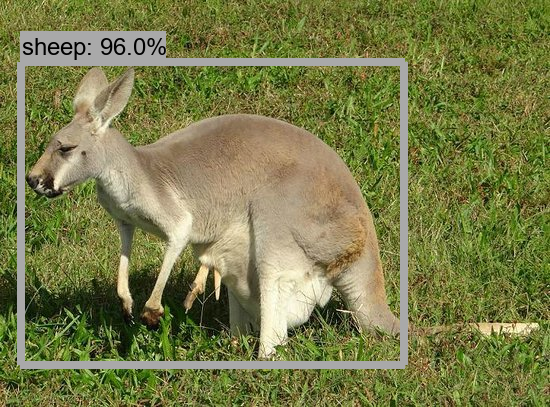

In [24]:
augment_data_model(True)